In [47]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import lime.lime_tabular
import shap

In [2]:
df = pd.read_csv('/home/tteofili/Downloads/SBAnational.csv')
df.head()

/home/tteofili/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [3]:
bad_columns = ['LoanNr_ChkDgt', 'NAICS', 'ApprovalDate', 'DisbursementDate', 'Name', 'FranchiseCode']
target = 'MIS_Status'
categorical = ['City', 'State', 'Zip', 'Bank', 'BankState', 'NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc']
ordinal = ['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob']
money_columns = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
date_col = ['ChgOffDate']

In [4]:
# drop bad columns
df = df.dropna()
df = df.drop(columns=bad_columns)

In [6]:
# convert date to ordinal days
import datetime as dt
for c in date_col:
    df[c] = pd.to_datetime(df[c]).map(dt.datetime.toordinal)

In [5]:
# encode labels
le = sklearn.preprocessing.LabelEncoder()
df[target] = le.fit_transform(df[target].astype(str))
class_names = le.classes_
print(class_names)

['CHGOFF' 'P I F']


In [7]:
# process ordinal features
df['ApprovalFY'] = pd.to_numeric(df['ApprovalFY'].replace('1976A','1976', regex=False).replace('\d+\-\w+\-\d+|,','', regex=True))
for col in ordinal:
    df[col] = df[col].astype('int32')

In [8]:
# process money columns
for c in money_columns:
    df[c] = df[c].replace('\$|,','', regex=True).replace('\(','-', regex=True).replace('\)','', regex=True)
    df[c] = pd.to_numeric(df[c])

In [11]:
# process categorical features
cat_idxs = [df.columns.get_loc(c) for c in categorical if c in df]
print(cat_idxs)
categorical_names = {}
for c in categorical:
    le = preprocessing.LabelEncoder()
    df[c] = le.fit_transform(df[c])
    categorical_names[c] = le.classes_

[0, 1, 2, 3, 4, 8, 11, 12, 13]


In [12]:
df.head()

,City,State,Zip,Bank,BankState,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
6,13801,31,1398,3393,43,1980,1980,1980,2,1980,...,0,2,3,727007,600000.0,0.0,0,208959.0,600000.0,499998.0
36,6727,35,8859,930,36,1997,1997,1997,1,1997,...,0,2,6,730958,47000.0,0.0,0,14084.0,47000.0,37600.0
43,3773,15,9249,1987,16,1980,1980,1980,2,1980,...,0,5,3,726379,197485.0,0.0,0,44374.0,200000.0,150000.0
58,2311,21,933,3393,43,2006,2006,2006,1,2006,...,1,0,3,735410,1350000.0,0.0,0,1043508.0,1350000.0,1012500.0
60,13187,22,10131,3393,43,1997,1997,1997,1,1997,...,0,0,3,732223,25000.0,0.0,0,23484.0,25000.0,12500.0


In [10]:
# Split X and Y
Y = df[target]
X = df.drop(columns=[target])

# Split the data into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

[7.66530222e-03 5.07185008e-03 3.29905645e-02 1.81377258e-02
 9.09580662e-03 2.19306249e-03 6.48882923e-04 3.11207932e-04
 3.30598483e-03 4.11829866e-03 1.01348963e-02 0.00000000e+00
 4.44717426e-03 0.00000000e+00 1.70640162e-01 3.53523831e-02
 0.00000000e+00 6.57092416e-01 2.20387460e-02 1.67555364e-02]


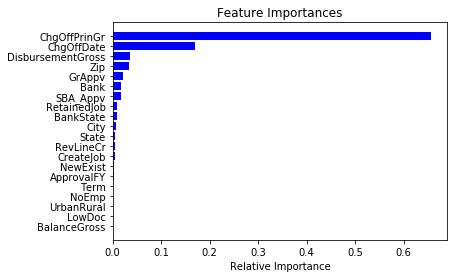

0.9690442890442891

In [91]:
dt = DecisionTreeClassifier(max_depth=7)
dt.fit(X_train, Y_train)  
print(dt.feature_importances_)
importances = dt.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
sklearn.metrics.accuracy_score(Y_test, dt.predict(X_test))

In [107]:
t = df.loc[df[target] == 1].iloc[0]
print(t[target])
t = t.drop(columns=[target])
t.shape

1.0
1.0


(21,)

In [85]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
out = dt.predict(X_test) 

print(confusion_matrix(Y_test,out))
print(classification_report(Y_test,out))
print(accuracy_score(Y_test, out))

[[31172    15]
 [  983     5]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     31187
           1       0.25      0.01      0.01       988

    accuracy                           0.97     32175
   macro avg       0.61      0.50      0.50     32175
weighted avg       0.95      0.97      0.95     32175

0.968982128982129


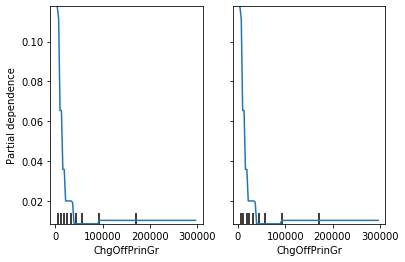

In [86]:
from sklearn.inspection import plot_partial_dependence
features = [17, (17)]
plot_partial_dependence(dt, X_train, features)

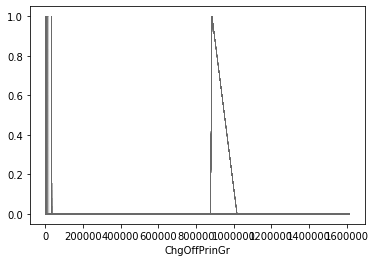

In [87]:
from pycebox.ice import ice, ice_plot
f = 'ChgOffPrinGr'
ice_df = ice(data=X_train[0:2000], column=f, 
                   predict=dt.predict)
ice_plot(ice_df, c='dimgray', linewidth=0.3)
plt.ylabel('')
plt.xlabel(f);

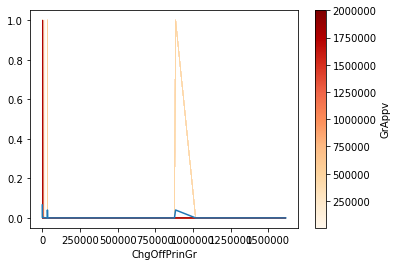

In [88]:
cmap2 = plt.get_cmap('OrRd')
cb = 'GrAppv'
ice_plot(ice_df, linewidth=0.5, color_by=cb, cmap=cmap2, plot_pdp=True)
cb_vals = ice_df.columns.get_level_values(cb).values
sm = plt.cm.ScalarMappable(cmap=cmap2, 
                           norm=plt.Normalize(vmin=cb_vals.min(), 
                                              vmax=cb_vals.max()))
sm._A = []
plt.colorbar(sm, label=cb)
plt.ylabel('')
plt.xlabel(f);

In [89]:
predict_fn = lambda x: dt.predict_proba(x).astype(float)

# 0 = CHGOFF, 1 = PIF
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X_train.columns, class_names=['CHGOFF', 'PIF'], discretize_continuous=False, 
                                                   categorical_names=categorical_names, kernel_width=5, mode='classification', verbose=True)

In [90]:
idx = 6
sample = X_test.iloc[idx]
sample_label = Y_test.iloc[idx]
print(sample)
print('Label: '+str(class_names[sample_label]))
xt = sample.to_numpy().reshape(-1,1)
print('Output: '+str(predict_fn(xt.T)))
exp = explainer.explain_instance(sample, predict_fn, num_features=2, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

City                   6624.0
State                    18.0
Zip                   13632.0
Bank                   2967.0
BankState                 4.0
ApprovalFY             2007.0
Term                   2007.0
NoEmp                  2007.0
NewExist                  1.0
CreateJob              2007.0
RetainedJob            2007.0
UrbanRural                1.0
RevLineCr                 0.0
LowDoc                    3.0
ChgOffDate           734500.0
DisbursementGross      7500.0
BalanceGross              0.0
ChgOffPrinGr           5466.0
GrAppv                 7500.0
SBA_Appv               6375.0
Name: 253752, dtype: float64
Label: CHGOFF
Output: [[0.95806681 0.04193319]]
Intercept 0.9257646120672716
Prediction_local [0.87100886]
Right: 0.9580668088130775


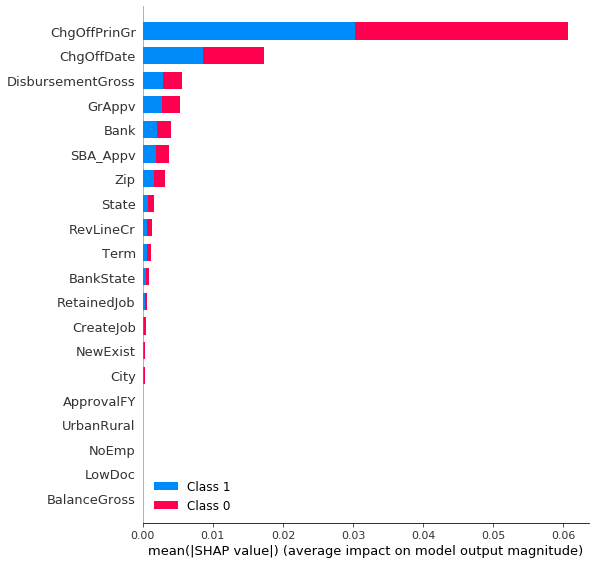

In [56]:
shap_values = shap.TreeExplainer(dt).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

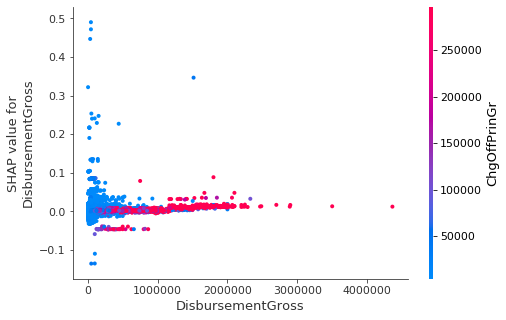

In [35]:
shap.dependence_plot("DisbursementGross", np.array(shap_values)[1], X_train)

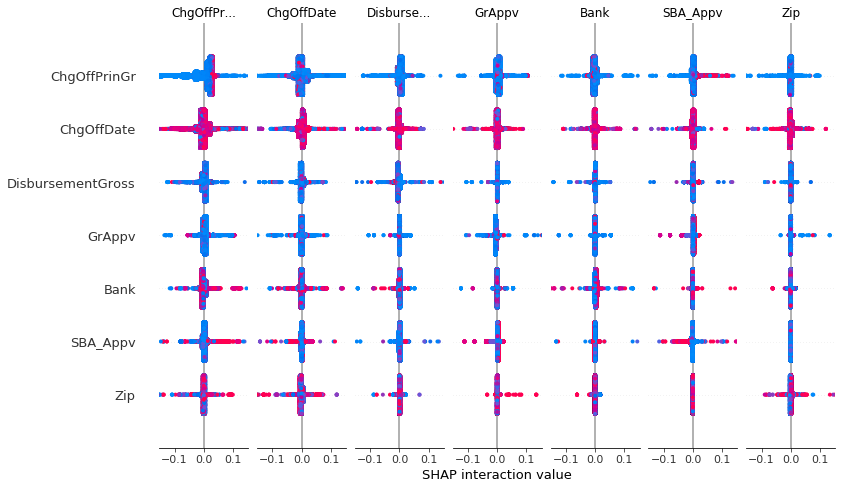

In [58]:
shap_interaction_values = shap.TreeExplainer(dt).shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values[0], X_train)

(2, 128696, 20)


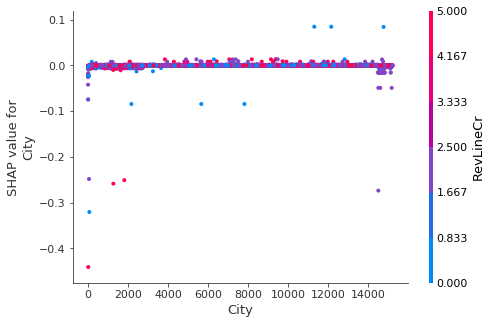

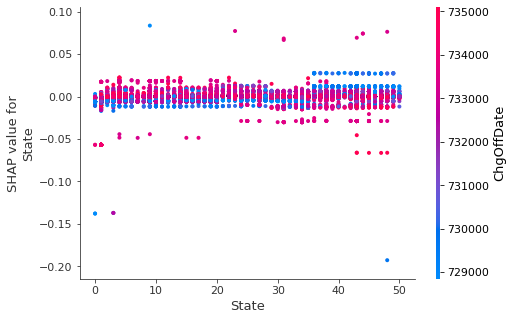

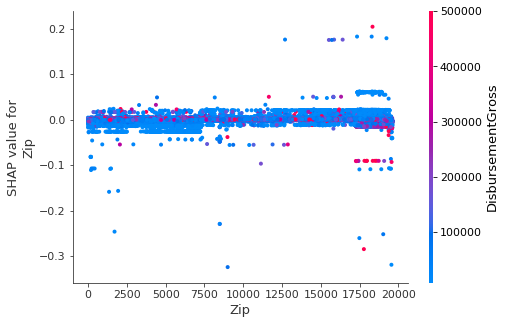

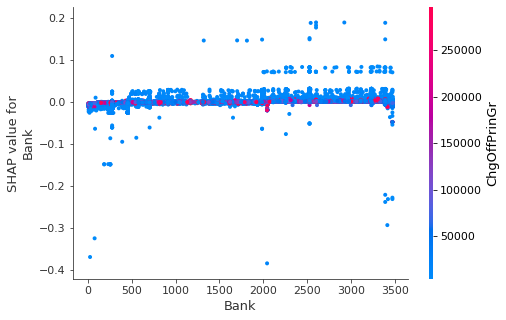

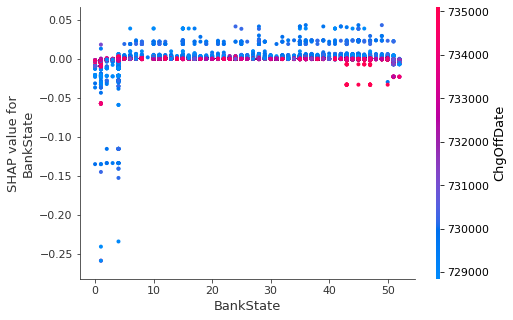

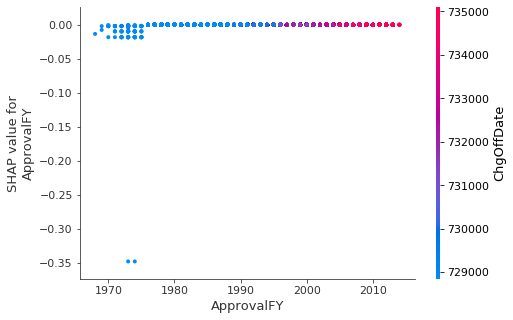

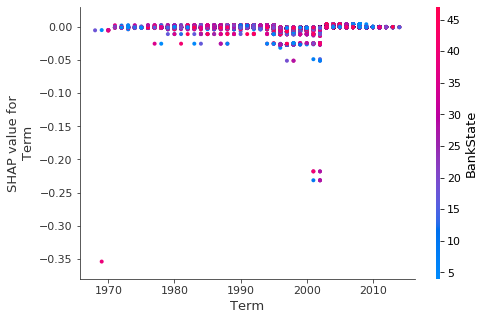

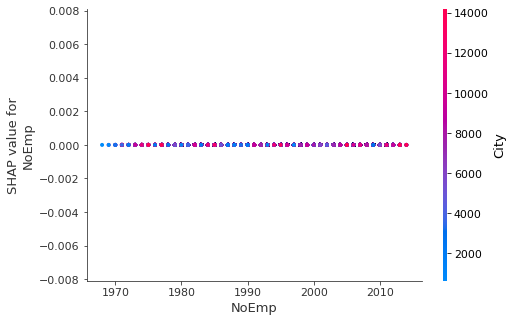

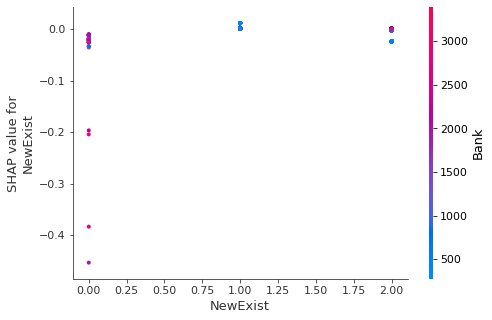

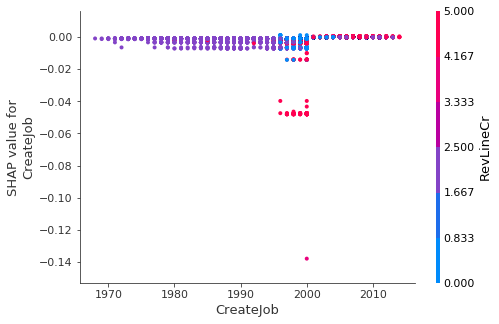

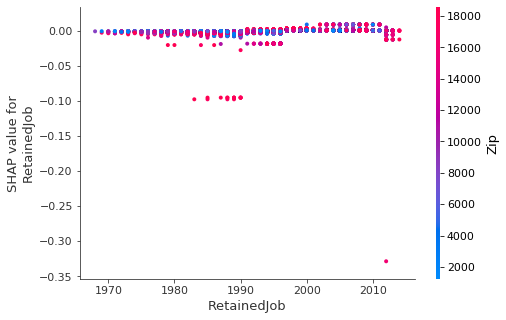

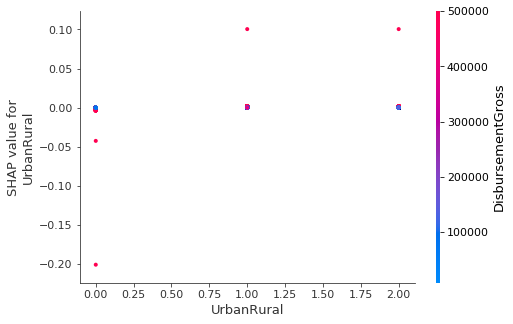

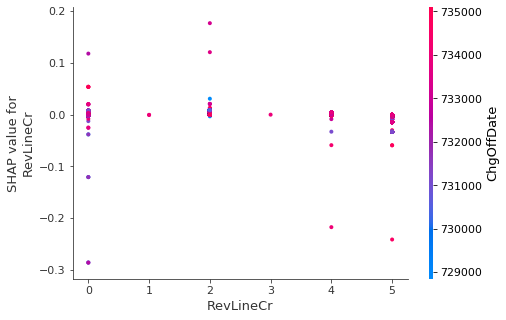

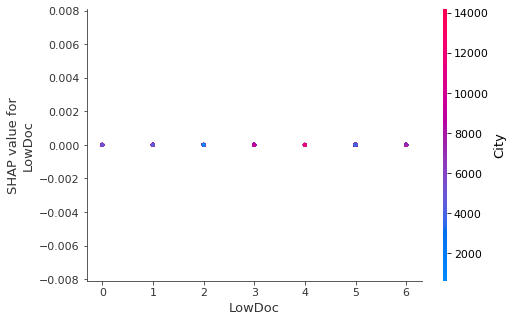

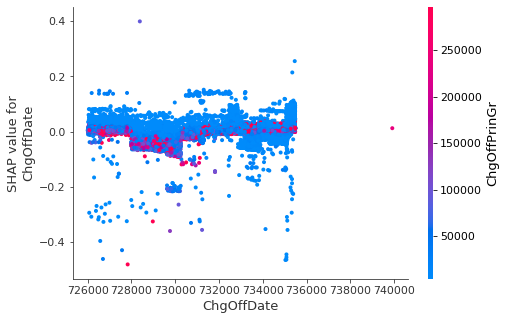

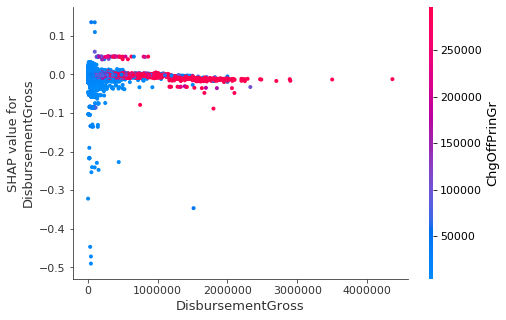

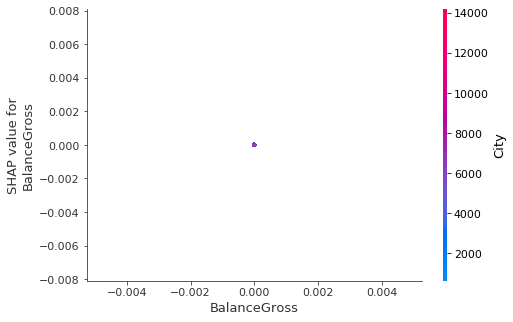

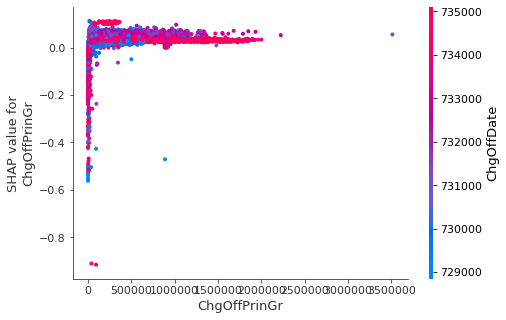

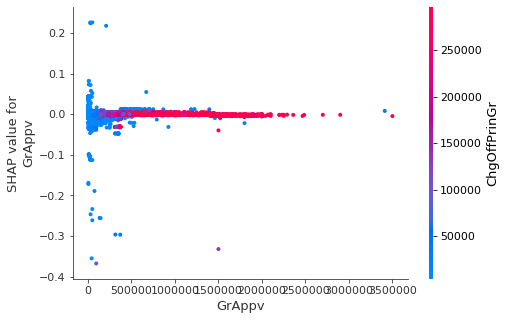

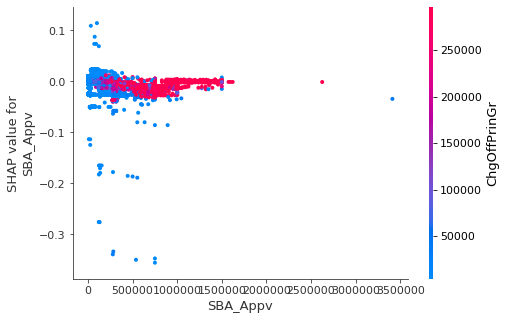

In [65]:
print(np.array(shap_values).shape)
for name in X_train.columns:
    shap.dependence_plot(name, np.array(shap_values)[0], X_train)